# Title 1

## 📋 Required Packages and Imports

This cell imports all necessary packages for Azure AI Agents with Semantic Kernel and checks the environment setup.

In [61]:
# Let's import everything we need and set up our environment
import asyncio
import os
from typing import Annotated

from azure.identity.aio import DefaultAzureCredential
from semantic_kernel.agents import AzureAIAgent, AzureAIAgentSettings, AzureAIAgentThread
from semantic_kernel.functions import kernel_function

print("📦 All packages imported successfully!")
print("\n🔧 Environment check:")

# Check if we're in a Jupyter environment for async handling
try:
    # Check if we're in Jupyter
    get_ipython()
    print("✅ Jupyter environment detected - async code will work properly")
except NameError:
    print("ℹ️  Running outside Jupyter - using asyncio.run() for async functions")

print("\n🎉 Setup complete! Ready to create your first agent.")

📦 All packages imported successfully!

🔧 Environment check:
✅ Jupyter environment detected - async code will work properly

🎉 Setup complete! Ready to create your first agent.


## 🔍 Environment Variables Check

This cell checks if all required Azure environment variables are set and displays their status.

In [62]:
required_vars = ['AZURE_OPENAI_ENDPOINT', 'AZURE_OPENAI_API_KEY', 'AZURE_OPENAI_DEPLOYMENT_NAME', 'AI_FOUNDRY_PROJECT_ENDPOINT', 'MODEL_DEPLOYMENT_NAME']
missing_vars = []

for var in required_vars:
    if var not in os.environ:
        missing_vars.append(var)
    else:
        print(f"✅ {var} is set")

if missing_vars:
    print(f"\n❌ Missing environment variables: {missing_vars}")
    print("\n🔧 Please set them using:")
    for var in missing_vars:
        print(f"   os.environ['{var}'] = 'your_value_here'")
else:
    print("\n🎉 All environment variables are properly configured!")

✅ AZURE_OPENAI_ENDPOINT is set
✅ AZURE_OPENAI_API_KEY is set
✅ AZURE_OPENAI_DEPLOYMENT_NAME is set
✅ AI_FOUNDRY_PROJECT_ENDPOINT is set
✅ MODEL_DEPLOYMENT_NAME is set

🎉 All environment variables are properly configured!


In [63]:
# 🔧 Interactive Environment Variable Setup
# Run this cell to set the missing environment variables

print("🔧 Setting up missing environment variables...")
print("Please provide the following information from your Azure resources:\n")

# Set AZURE_OPENAI_DEPLOYMENT_NAME
if 'AZURE_OPENAI_DEPLOYMENT_NAME' not in os.environ:
    deployment_name = input("Enter your Azure OpenAI deployment name (e.g., 'gpt-4', 'gpt-35-turbo'): ").strip()
    if deployment_name:
        os.environ['AZURE_OPENAI_DEPLOYMENT_NAME'] = deployment_name
        print(f"✅ AZURE_OPENAI_DEPLOYMENT_NAME set to: {deployment_name}")

# Set AI_FOUNDRY_PROJECT_ENDPOINT  
if 'AI_FOUNDRY_PROJECT_ENDPOINT' not in os.environ:
    project_endpoint = input("Enter your AI Foundry project endpoint (e.g., 'https://your-project.region.models.ai.azure.com'): ").strip()
    if project_endpoint:
        os.environ['AI_FOUNDRY_PROJECT_ENDPOINT'] = project_endpoint
        print(f"✅ AI_FOUNDRY_PROJECT_ENDPOINT set to: {project_endpoint}")

# Set MODEL_DEPLOYMENT_NAME (this might be the same as AZURE_OPENAI_DEPLOYMENT_NAME)
if 'MODEL_DEPLOYMENT_NAME' not in os.environ:
    print("\n💡 Note: MODEL_DEPLOYMENT_NAME is often the same as your Azure OpenAI deployment name")
    use_same = input("Use the same name as AZURE_OPENAI_DEPLOYMENT_NAME? (y/n): ").strip().lower()
    
    if use_same == 'y' and 'AZURE_OPENAI_DEPLOYMENT_NAME' in os.environ:
        os.environ['MODEL_DEPLOYMENT_NAME'] = os.environ['AZURE_OPENAI_DEPLOYMENT_NAME']
        print(f"✅ MODEL_DEPLOYMENT_NAME set to: {os.environ['AZURE_OPENAI_DEPLOYMENT_NAME']}")
    else:
        model_name = input("Enter your model deployment name: ").strip()
        if model_name:
            os.environ['MODEL_DEPLOYMENT_NAME'] = model_name
            print(f"✅ MODEL_DEPLOYMENT_NAME set to: {model_name}")

print("\n🎉 Environment variables setup complete!")
print("\n📝 Summary of all required variables:")
for var in ['AZURE_OPENAI_ENDPOINT', 'AZURE_OPENAI_API_KEY', 'AZURE_OPENAI_DEPLOYMENT_NAME', 'AI_FOUNDRY_PROJECT_ENDPOINT', 'MODEL_DEPLOYMENT_NAME']:
    status = "✅ SET" if var in os.environ else "❌ MISSING"
    print(f"   {var}: {status}")

🔧 Setting up missing environment variables...
Please provide the following information from your Azure resources:


🎉 Environment variables setup complete!

📝 Summary of all required variables:
   AZURE_OPENAI_ENDPOINT: ✅ SET
   AZURE_OPENAI_API_KEY: ✅ SET
   AZURE_OPENAI_DEPLOYMENT_NAME: ✅ SET
   AI_FOUNDRY_PROJECT_ENDPOINT: ✅ SET
   MODEL_DEPLOYMENT_NAME: ✅ SET


In [64]:
# Check if Azure CLI is logged in
import subprocess
import shutil
import json

def is_az_logged_in():
    az_path = shutil.which("az")
    if not az_path:
        print("❌ Azure CLI (az) not found in PATH.")
        return False

    try:
        result = subprocess.run(
            [az_path, "account", "show", "--output", "json"],
            capture_output=True,
            text=True,
            check=True
        )
        account_info = json.loads(result.stdout)
        print(f"✅ Logged in as: {account_info['user']['name']}")
        return True
    except subprocess.CalledProcessError:
        print("❌ Not logged in or error during az call. Please log in using 'az login' from the terminal.")
        return False

_ = is_az_logged_in()


✅ Logged in as: admin@MngEnvMCAP379459.onmicrosoft.com


## 🗄️ CosmosDB Plugin Implementation

This cell creates a production-ready Cosmos DB plugin that connects to Azure Cosmos DB for retrieving insurance claim documents. Includes multiple kernel functions for querying by claim_id, document ID, custom SQL queries, field searches, and container management.

In [ ]:
import json
from typing import List, Dict, Any, Optional

class CosmosDBPlugin:
    """
    A production-ready Cosmos DB plugin that connects to real Azure Cosmos DB.
    This plugin retrieves actual JSON documents from your database.
    """
    
    def __init__(self, endpoint: str = None, key: str = None, database_name: str = "MyDatabase", container_name: str = "MyContainer"):
        """
        Initialize the Cosmos DB plugin with connection details.
        For production, use environment variables or Azure Key Vault for credentials.
        """
        self.endpoint = endpoint or os.environ.get("COSMOS_ENDPOINT")
        self.key = key or os.environ.get("COSMOS_KEY") 
        self.database_name = "insurance_claims"
        self.container_name = "crash_reports"
        
        # Validate required connection parameters
        if not self.endpoint:
            print("⚠️ COSMOS_DB_ENDPOINT environment variable not set")
        if not self.key:
            print("⚠️ COSMOS_DB_KEY environment variable not set")
            print("💡 Consider using Managed Identity in production instead of keys")
    
    def _get_cosmos_client(self):
        """Create and return a Cosmos DB client."""
        try:
            from azure.cosmos import CosmosClient
            return CosmosClient(self.endpoint, self.key)
        except ImportError:
            raise ImportError("azure-cosmos package not installed. Run: pip install azure-cosmos")
        except Exception as e:
            raise Exception(f"Failed to create Cosmos DB client: {str(e)}")
    
    @kernel_function(description="Retrieve a document by claim_id from Cosmos DB using cross-partition query")
    def get_document_by_claim_id(
        self, 
        claim_id: Annotated[str, "The claim_id to retrieve (not the partition key)"]
    ) -> Annotated[str, "JSON document from Cosmos DB"]:
        """Retrieve a document by its claim_id using a cross-partition query."""
        try:
            client = self._get_cosmos_client()
            database = client.get_database_client(self.database_name)
            container = database.get_container_client(self.container_name)
            
            # Use SQL query to find document by claim_id across all partitions
            query = "SELECT * FROM c WHERE c.claim_id = @claim_id"
            parameters = [{"name": "@claim_id", "value": claim_id}]
            
            items = list(container.query_items(
                query=query,
                parameters=parameters,
                enable_cross_partition_query=True,
                max_item_count=1  # We expect only one document with this claim_id
            ))
            
            if not items:
                return f"❌ No document found with claim_id '{claim_id}' in container '{self.container_name}'"
            
            # Return the first (and should be only) matching document
            document = items[0]
            return json.dumps(document, indent=2, ensure_ascii=False)
            
        except Exception as e:
            error_msg = str(e)
            if "Unauthorized" in error_msg or "401" in error_msg:
                return f"❌ Authentication failed. Please check your Cosmos DB credentials."
            elif "Forbidden" in error_msg or "403" in error_msg:
                return f"❌ Access denied. Please check your Cosmos DB permissions."
            else:
                return f"❌ Error retrieving document by claim_id '{claim_id}': {error_msg}"
    
    @kernel_function(description="Retrieve a JSON document by partition key and document ID from Cosmos DB")
    def get_document_by_id(
        self, 
        document_id: Annotated[str, "The document ID to retrieve"],
        partition_key: Annotated[str, "The partition key value (optional, will use cross-partition query if not provided)"] = None
    ) -> Annotated[str, "JSON document from Cosmos DB"]:
        """Retrieve a specific document by its ID and optionally partition key from Cosmos DB."""
        try:
            client = self._get_cosmos_client()
            database = client.get_database_client(self.database_name)
            container = database.get_container_client(self.container_name)
            
            if partition_key:
                # Direct read using partition key - most efficient
                item = container.read_item(item=document_id, partition_key=partition_key)
                return json.dumps(item, indent=2, ensure_ascii=False)
            else:
                # Cross-partition query when partition key is unknown
                query = "SELECT * FROM c WHERE c.id = @document_id"
                parameters = [{"name": "@document_id", "value": document_id}]
                
                items = list(container.query_items(
                    query=query,
                    parameters=parameters,
                    enable_cross_partition_query=True,
                    max_item_count=1
                ))
                
                if not items:
                    return f"❌ Document with ID '{document_id}' not found in container '{self.container_name}'"
                
                return json.dumps(items[0], indent=2, ensure_ascii=False)
            
        except Exception as e:
            error_msg = str(e)
            if "NotFound" in error_msg or "404" in error_msg:
                return f"❌ Document with ID '{document_id}' not found in container '{self.container_name}'"
            elif "Unauthorized" in error_msg or "401" in error_msg:
                return f"❌ Authentication failed. Please check your Cosmos DB credentials."
            elif "Forbidden" in error_msg or "403" in error_msg:
                return f"❌ Access denied. Please check your Cosmos DB permissions."
            else:
                return f"❌ Error retrieving document: {error_msg}"
    
    @kernel_function(description="Query documents with a custom SQL query in Cosmos DB")
    def query_documents(
        self, 
        sql_query: Annotated[str, "SQL query to execute (e.g., 'SELECT * FROM c WHERE c.category = \"electronics\"')"]
    ) -> Annotated[str, "Query results as JSON"]:
        """Execute a custom SQL query against the Cosmos DB container."""
        try:
            client = self._get_cosmos_client()
            database = client.get_database_client(self.database_name)
            container = database.get_container_client(self.container_name)
            
            # Execute the query
            items = list(container.query_items(
                query=sql_query,
                enable_cross_partition_query=True  # Enable if your query spans partitions
            ))
            
            if not items:
                return f"🔍 No documents found matching query: {sql_query}"
            
            # Return results as formatted JSON
            result = {
                "query": sql_query,
                "count": len(items),
                "results": items
            }
            
            return json.dumps(result, indent=2, ensure_ascii=False)
            
        except Exception as e:
            error_msg = str(e)
            if "Syntax error" in error_msg:
                return f"❌ SQL syntax error in query: {sql_query}\nError: {error_msg}"
            else:
                return f"❌ Error executing query: {error_msg}"
    
    @kernel_function(description="Get container information and statistics")
    def get_container_info(self) -> Annotated[str, "Container information and statistics"]:
        """Get information about the Cosmos DB container."""
        try:
            client = self._get_cosmos_client()
            database = client.get_database_client(self.database_name)
            container = database.get_container_client(self.container_name)
            
            # Get container properties
            container_props = container.read()
            
            # Get approximate document count (this is an estimate)
            count_query = "SELECT VALUE COUNT(1) FROM c"
            count_items = list(container.query_items(
                query=count_query,
                enable_cross_partition_query=True
            ))
            document_count = count_items[0] if count_items else "Unknown"
            
            info = {
                "database": self.database_name,
                "container": self.container_name,
                "partition_key": container_props.get("partitionKey", {}).get("paths", ["Unknown"]),
                "approximate_document_count": document_count,
                "indexing_policy": container_props.get("indexingPolicy", {}).get("indexingMode", "Unknown")
            }
            
            return json.dumps(info, indent=2)
            
        except Exception as e:
            return f"❌ Error getting container info: {str(e)}"
    
    @kernel_function(description="List recent documents (up to 100) from Cosmos DB")
    def list_recent_documents(
        self, 
        limit: Annotated[int, "Maximum number of documents to return (default: 10, max: 100)"] = 10
    ) -> Annotated[str, "List of recent documents"]:
        """List recent documents from the container."""
        try:
            # Ensure limit is within bounds
            limit = max(1, min(limit, 100))
            
            client = self._get_cosmos_client()
            database = client.get_database_client(self.database_name)
            container = database.get_container_client(self.container_name)
            
            # Query for documents (ordered by _ts if available)
            query = f"SELECT TOP {limit} * FROM c ORDER BY c._ts DESC"
            
            items = list(container.query_items(
                query=query,
                enable_cross_partition_query=True
            ))
            
            if not items:
                return "📭 No documents found in the container"
            
            result = {
                "container": self.container_name,
                "count": len(items),
                "documents": items
            }
            
            return json.dumps(result, indent=2, ensure_ascii=False)
            
        except Exception as e:
            return f"❌ Error listing documents: {str(e)}"
    
    @kernel_function(description="Search documents by field value")
    def search_by_field(
        self, 
        field_name: Annotated[str, "The field name to search in (e.g., 'name', 'category', 'status')"],
        field_value: Annotated[str, "The value to search for"]
    ) -> Annotated[str, "Documents matching the search criteria"]:
        """Search for documents where a specific field matches a value."""
        try:
            client = self._get_cosmos_client()
            database = client.get_database_client(self.database_name)
            container = database.get_container_client(self.container_name)
            
            # Use parameterized query for better security and performance
            query = f"SELECT * FROM c WHERE c.{field_name} = @field_value"
            parameters = [{"name": "@field_value", "value": field_value}]
            
            items = list(container.query_items(
                query=query,
                parameters=parameters,
                enable_cross_partition_query=True
            ))
            
            if not items:
                return f"🔍 No documents found where {field_name} = '{field_value}'"
            
            result = {
                "search_criteria": f"{field_name} = '{field_value}'",
                "count": len(items),
                "documents": items
            }
            
            return json.dumps(result, indent=2, ensure_ascii=False)
            
        except Exception as e:
            return f"❌ Error searching documents: {str(e)}"

# Create an instance of the real Cosmos DB plugin
cosmos_plugin = CosmosDBPlugin()

## 🚀 Test Claim Reviewer Agent

This cell creates and tests an Azure AI Agent configured as a claim assessor that connects to Cosmos DB to retrieve claim information and perform detailed damage evaluation and cost assessment with validation capabilities.

In [66]:
# Create a global client that can be reused
global_client = None

async def get_or_create_client():
    """Get existing client or create a new one if it doesn't exist."""
    global global_client
    
    if global_client is None:
        print("🔧 Creating new Azure AI Agent client...")
        global_client = AzureAIAgent.create_client(
            credential=DefaultAzureCredential(), 
            endpoint=os.environ.get("AI_FOUNDRY_PROJECT_ENDPOINT")
        )
        print("✅ Client created successfully")
    else:
        print("♻️ Reusing existing Azure AI Agent client")
    
    return global_client

# Modified function to reuse existing client
async def create_claim_agent():
    """Create and return the claim agent for reuse across cells."""
    
    print("🚀 Creating Claim Reviewer Agent")
    print("=" * 60)
    
    try:
        # Get or reuse existing client
        client = await get_or_create_client()
        
        # Create agent definition with updated instructions
        agent_definition = await client.agents.create_agent(
            model=os.environ.get("MODEL_DEPLOYMENT_NAME"),
            name="claim_reviewer",
            instructions="""You are a claim assessor specializing in damage evaluation and cost assessment.

To start, you can retrieve JSON documents by claim_id, document ID, execute custom queries, search by field values, and provide information about the database.
Always format JSON responses in a readable way and explain what the data represents when possible.

Available functions:
- get_document_by_claim_id: Use this when users ask for information about a specific claim
- get_document_by_id: Use this when users provide a document ID and optionally a partition key
- search_by_field: Use this to find documents by any field value
- query_documents: Use this for complex SQL queries
- get_container_info: Use this to get database information
- list_recent_documents: Use this to show recent documents

When users ask for claim information, always use get_document_by_claim_id function.

Then, with the information retrieved from the database, your responsibilites are:
    - Evaluate the consistency between incident description and claimed damage.
    - Assess the reasonableness of estimated repair costs.
    - Verify supporting documentation (photos, police reports, witness statements).
    - Use vehicle details to validate damage estimates.
    - Identify any red flags or inconsistencies.

CRITICAL:
    Inside the retrieved claim, you will find a "image_descriptions" field containing image descriptions generated by generative AI. Please use 
    these descriptions to inform your assessment and look for any inconsistencies.

Provide detailed assessments with specific cost justifications that incorporate vehicle details and insights derived from images.
End your assessment with: VALID, QUESTIONABLE, or INVALID."""
        )
        
        # Create agent with the Cosmos DB plugin
        claim_agent = AzureAIAgent(
            client=client,
            definition=agent_definition,
            plugins=[cosmos_plugin]
        )
        
        print(f"✅ Created agent: {claim_agent.name}")
        return claim_agent, client  # Return both agent and client
        
    except Exception as e:
        print(f"❌ Error creating agent: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# Create the global claim agent and get the client
claim_agent, client = await create_claim_agent()

if claim_agent:
    print("\n🎯 Claim agent is now available for use!")
    print(f"📱 Client is also available globally as 'client'")
    
    # Test with initial questions
    test_questions = [
        "Tell me your assessment for claim CL002",
        "Retrieve information for claim CL001"
    ]
    
    print(f"\n💬 Testing with {len(test_questions)} questions...")
    print("=" * 60)
    
    claim_thread = None
    
    for i, question in enumerate(test_questions, 1):
        print(f"\n{i}. 👤 User: {question}")
        
        try:
            response = await claim_agent.get_response(
                messages=question,
                thread=claim_thread
            )
            
            print(f"   🤖 Agent: {response}")
            claim_thread = response.thread
            print("-" * 60)
            
        except Exception as e:
            print(f"   ❌ Error with question {i}: {str(e)}")
            print("-" * 60)
    
    print(f"\n✅ Agent test completed!")
else:
    print("❌ Failed to create claim agent")

🚀 Creating Claim Reviewer Agent
🔧 Creating new Azure AI Agent client...
✅ Client created successfully
✅ Created agent: claim_reviewer

🎯 Claim agent is now available for use!
📱 Client is also available globally as 'client'

💬 Testing with 2 questions...

1. 👤 User: Tell me your assessment for claim CL002
   🤖 Agent: Claim ID: CL002
Claimant: Samantha Turner
Vehicle: 2017 Honda Civic Hatchback

Incident and Damage Summary:
- Incident involved a side-impact collision where another vehicle ran a red light and struck the claimant's vehicle on the driver’s side.
- Damage reported includes heavy structural intrusion on the driver’s front and rear doors, compromised B-pillar, rear wheel misalignment, shattered rear driver’s side window, paint transfer, deployment of side airbags, and possible interior damage to door controls.
- Vehicle was towed from the scene.

Image Description Analysis:
- The attached image from a Euro NCAP side-impact crash test shows extensive deformation on the driver's

## 🔄Step 5: Multi-turn Conversations
One of the most powerful features of Semantic Kernel agents is context retention. Let's have a multi-turn conversation to see this in action!

In [67]:
if 'claim_agent' in globals() and claim_agent and 'claim_thread' in globals() and claim_thread:
    conversation_questions = [
        "Client CL002 has submitted a claim for a car accident. Can you provide more details about the damage assessment methodology you used?",
        "The impacted car was an Honda Civic 2017, do you have any information about the estimated repair costs?", 
        "How would you recommend the insurance company proceed with this claim?"
    ]
    
    print("🔄 Multi-turn Claim Assessment Conversation:")
    print("═" * 50)
    
    for i, question in enumerate(conversation_questions, 1):
        try:
            print(f"\n{i}. 👤 User: {question}")
            
            # Each call builds on the previous conversation
            response = await claim_agent.get_response(
                messages=question,
                thread=claim_thread
            )
            
            print(f"   🤖 {response.name}: {response}")
            
            # Always update the thread reference
            claim_thread = response.thread
            
        except Exception as e:
            print(f"   ❌ Error: {e}")
            break    
else:
    print("⚠️ Cannot continue conversation - missing claim agent or thread")
    print("💡 Please run the cell above to create the claim agent first")



🔄 Multi-turn Claim Assessment Conversation:
══════════════════════════════════════════════════

1. 👤 User: Client CL002 has submitted a claim for a car accident. Can you provide more details about the damage assessment methodology you used?
   🤖 claim_reviewer: For claim CL002 involving a 2017 Honda Civic Hatchback struck on the driver’s side in a side-impact collision, the damage assessment methodology incorporated multiple key elements:

1. Incident Description Analysis:
- Reviewed the narrative provided by the claimant describing the high-energy side impact, vehicle spin, and final vehicle position.
- Considered details such as the failure of the opposing vehicle to stop at a red light and the resulting impact location (driver’s side).

2. Damage Description Correlation:
- Compared the reported damages: heavy intrusion on driver’s front and rear doors, compromised B-pillar, shattered driver’s side rear window, misaligned rear wheel, paint transfer, and airbag deployment.
- Evaluated

Awesome! We have now created sussecufully another Azure AI Agent Service, but now, with the integration of Semantic Kernel plugins to help retrieve data from a Azure Cosmos DB service. If you go back to your Azure Foundry, and go back to your Agents section, you'll be able to see both your newly created `claim_reviewer` agent, as well as your previously created `policy-checker` agent:


 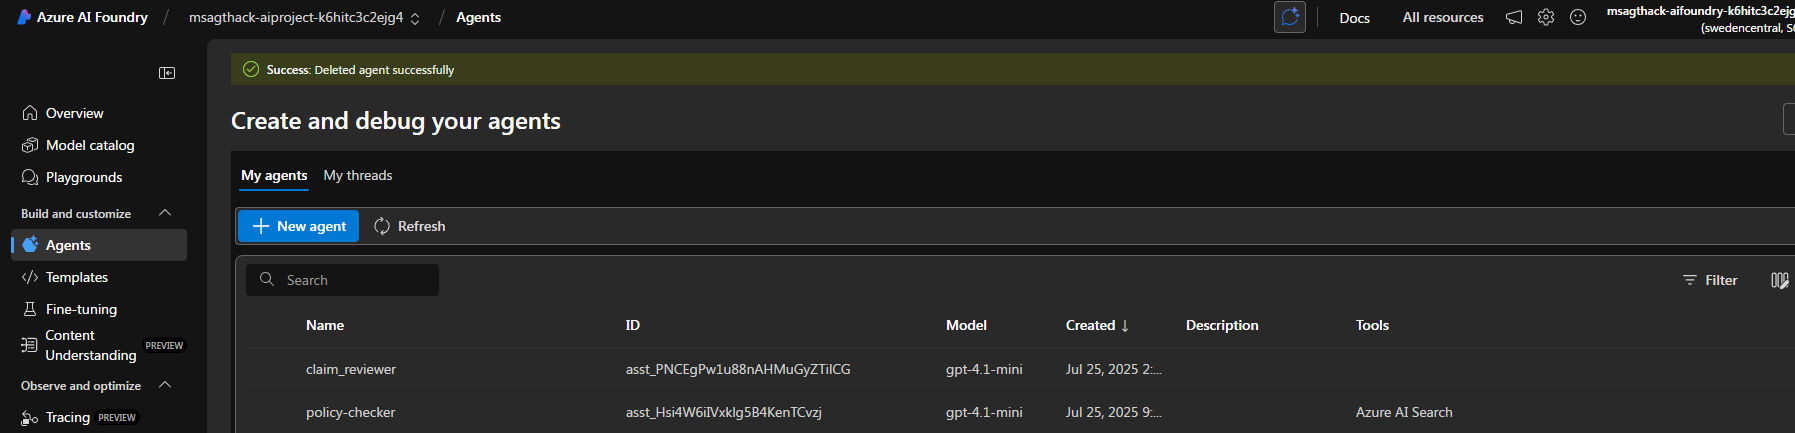

What you'll also notice is that close to the `My Agents` section, you can also find the `My threads` section. This section allows you to check all the threads that have been created, which essentially stands by the Memory of your questions for a specific agent. Note that in the previous block of code we have added `claim_thread = response.thread` to save the message to the thread.

In [ ]:
print("💭 Exploring conversation history and context...")

# List all messages in the current thread
async for msg in client.agents.messages.list(thread_id=claim_thread.id):
    for m in msg.content:
        print("\n" + "="*80)
        print(f"🗨️ Message ID: {msg.id}")   
        print(f" - {m.type} message:\n{m.text.value}")
        print(80 * "-", "\n")

Therefore, each agent can have several threads, and each thread will have also multiple message_ids within it, as you can see by the output on the previous cell.

Now, it's time to go back to our `readme.md` file for Part 2 of our guide.